<a href="https://colab.research.google.com/github/joseortegalabra/MLBI/blob/master/Covid_resnet50_with_DataGenerator_Jos%C3%A9_Ignacio_Ortega_Labra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Certamen 1: Machine Learning for Business Intelligence.

## Instrucciones

1. Este certamen es de caracter individual, por lo tanto queda estrictamente prohibida la copia de codigo ajeno. **Cualquier copia será motivo de reprobación.**

2. En caso de elaborar su respuesta **basandose** en código ajeno encontrado en la web, debe agradecer al menos citando la referencia.

3. La fecha límite para la entrega de esta tarea queda establecida para el **02/07/2020 a la media noche**.

Nota: La resolución de algunos de los ejercicios puede tomar bastante tiempo, así como su ejecución. Por lo tanto se recomienda hacer la tarea con anticipación y evitar riesgos. Además, es **obligatorio el uso de Google Colab**.

## Pregunta 1 (y única).

La idea de este certamen es utilizar redes neuronales convolucionales para reproducir los resultados del reciente artículo [COVID-Net: A Tailored Deep Convolutional Neural Network Design for Detection of COVID-19 Cases from Chest X-Ray Images](https://arxiv.org/pdf/2003.09871.pdf) (L. Wang et al. 2020)

### Preprocesamiento (20 pts.)

Lo primero será crear un iterador que genere los batches con los cuales la red hara el forward y backward pass.
Recuerde que se cuenta con dos archivos .txt que contienen las rutas y etiquetas de nuestros datos. Por lo tanto nuestro iterador tiene ciertos objetivos generales:

1. Leer el archivo .txt
2. Abrir la imagen y guardarla como una matriz. Almacenar también la etiqueta respectiva para cada imagen.

Para cada una de las imagenes:
1. Desecharemos el 15% superior de la imagen, pues contiene información poco relevante.
2. Recortaremos la imagen de tal forma de que nos quede una matriz cuadrada.
3. Redimensionaremos la matriz a tamaño (256x256)

Algo indeseable para una red neuronal es el sobreajuste (i.e. que la red se aprenda los datos y sea incapaz de generalizar a nuevos datos que provengan de la misma distribución). Para evitar el sobreajuste, haremos pequeñas transformaciones sobre nuestras imágenes de **entrenamiento**, lo cual hará que nuestra red vea con muy poca probabilidad exactamente el mismo dato más de una vez:
1. Haremos un "flip" (simetria axial) de la imagen en el eje horizontal con una probabilidad de (0.5).
2. Recortaremos la imagen de manera aleatoria, dejándola finalmente de tamaño 224x224.
3. Haremos traslaciones de la imagen en el eje vertical y horizontal de +-4 pixeles (muestreando el valor de la traslación desde de una distribución uniforme).

Para las imagenes de **testeo**
1. Hacer un recorte del centro de la imagen, dejándola de tamaño 224x224


Finalmente, nuestro set de datos de entrenamiento se encuentra altamente desbalanceado. Para evitar que la red minimice su función de costos a través de la minimización de la clase más representativa, obteniendo mal rendimiento en el resto de las clases, se pide implementar una de estas dos soluciones:
1. Hacer que nuestro iterador genere por cada batch de datos una cantidad similar de datos por cada clase.
2. Pesar nuestra función de costos, añadiendo una penalización en caso de obtener mal rendimiento en las clases menos representadas.


**hint** Muchos de las transformaciones exigidas en este apartado se encuentran implementadas en Keras, TensorFlow, Pytorch. 

In [ ]:
import numpy as np
import tensorflow as tf
import keras as kr
from skimage import io
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from keras import Model
from keras.layers import Dense, Flatten
from keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.utils import class_weight
from sklearn.metrics import f1_score

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#cargar datos google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [ ]:
#path local
#path_train = 'train_split_v3.txt'
#path_test = 'test_split_v3.txt'

#path googledrive
path_train = '/content/drive/My Drive/Data_covid_RX/train_split_v3.txt'
path_test = '/content/drive/My Drive/Data_covid_RX/test_split_v3.txt'

In [ ]:
train_file = open(path_train, 'r')  #read file txt train
test_file = open(path_test, 'r')  #read file txt test 

In [ ]:
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>CREATE PATH IMAGES TRAIN Y TEST
list_names_train = []
for x in train_file:
    list_names_train.append(x)
    
list_names_test = []
for x in test_file:
    list_names_test.append(x)    #lista con path de cada imagen extraido de txt

##### Create path to image file



In [ ]:
def get_image_path(file_to_save, file_to_read, train_or_test):
    space = ' '
    for i, list_image_i in enumerate(file_to_read):
        #spaces para leer el path de la imagen
        index_first_space = list_image_i.index(space)   #primer espacio para el numero de muetra 
        index_second_space = list_image_i.index(space, index_first_space +1)   #segundo espacio para terminar el path del archivo
        #path de la imagen para leer
        image_path = list_image_i[index_first_space+1  :  index_second_space]
        image_path = train_or_test + image_path    #--->PATH DE LA IMAGEN A LEER
        file_to_save.append(image_path)

In [ ]:
#folder local pc 
#folder_images_train = 'data/train/'
#folder_images_test = 'data/test/'

#folder googledrive
folder_images_train = '/content/drive/My Drive/Data_covid_RX/train/'
folder_images_test = '/content/drive/My Drive/Data_covid_RX/test/'

In [ ]:
image_train_path = []    #list with path to each images
image_test_path = [] 

In [ ]:
get_image_path(image_train_path, list_names_train, folder_images_train)  #TRAIN lista con las direcciones de imagenes , image_train_path file saved train
get_image_path(image_test_path, list_names_test, folder_images_test)   #TEST  lista con las direcciones de imagenes, image_test_path file saved test

EXAMPLE VISUALIZATION FIRST IMAGE ORIGINAL - TRAIN


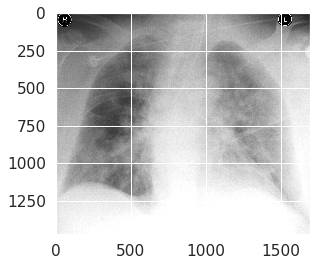

In [ ]:
print('EXAMPLE VISUALIZATION FIRST IMAGE ORIGINAL - TRAIN')
io.imshow(io.imread(image_train_path[0]))

EXAMPLE VISUALIZATION FIRST IMAGE ORIGINAL - TEST


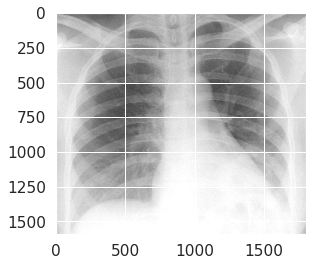

In [ ]:
print('EXAMPLE VISUALIZATION FIRST IMAGE ORIGINAL - TEST')
io.imshow(io.imread(image_test_path[0]))

##### Create path to image file

In [ ]:
#>>>>>>>>>>>>>>>>>>>CREATE LABELS y 0,1,2
## 0 NORMAL
# 1 PNEUMONIA
# 2 COVID-19
#Crear array y_train , y_test clasificado
def clasifique_img(name_string):     
    if('pneumonia' in name_string):
        return 1      #posicion i de la matriz de y para train
    if('COVID-19' in name_string):
        return 2
    if('normal' in name_string):
        return 0

def create_label(file_to_read):    #function to create labels, y_train , y_test
    file_to_write = np.zeros(len(file_to_read))
    for i, list_image_i in enumerate(file_to_read):
        file_to_write[i] = clasifique_img(list_image_i)
    return file_to_write

y_train_0 = np.zeros(len(list_names_train))   #create array to save data y
y_test_0 = np.zeros(len(list_names_test))

y_train_0 = create_label(list_names_train).astype('int')   #LABEL DEL TRAIN
y_test_0 = create_label(list_names_test).astype('int')   #LABELS DEL TEST

print('Number Data TRAIN', len(list_names_train))
print('Normal', (y_train_0 == 0).sum())
print('Pneumonia', (y_train_0 == 1).sum())
print('COVID-19', (y_train_0 == 2).sum())

print('\nNumber Data TEST', len(list_names_test))
print('Normal', (y_test_0 == 0).sum())
print('Pneumonia', (y_test_0 == 1).sum())
print('COVID-19', (y_test_0 == 2).sum())

Number Data TRAIN 13898
Normal 7966
Pneumonia 5504
COVID-19 428

Number Data TEST 1579
Normal 885
Pneumonia 610
COVID-19 84


##### Create a directory

In [ ]:
partition = {      #diccionario para guardar path de train y test
    'train': [x for x in image_train_path],
    'test': [x for x in image_test_path]
}

labels = {**dict(zip(image_train_path, y_train_0)), **dict(zip(image_test_path, y_test_0))}

In [ ]:
print('Example')
print('First image train')
print('path: ', partition['train'][0])
print('label: ', labels[  partition['train'][0]  ] )
print('\nFirst image test')
print('path: ', partition['test'][0])
print('label: ', labels[  partition['test'][0]  ] )

Example
First image train
path:  /content/drive/My Drive/Data_covid_RX/train/SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0.jpeg
label:  1

First image test
path:  /content/drive/My Drive/Data_covid_RX/test/SARS-10.1148rg.242035193-g04mr34g05x-Fig5-day9.jpeg
label:  1


#### Preprocesing

In [ ]:
#funciones para preprocesar train
def crop_square_center(x):
    h,w,_ = x.shape
    if(h>w):
        dif_h = h-w   #el alto es mayor
        dif_h_2 = int(dif_h/2)
        if(dif_h%2 ==1):  #la mitad de la dif del alto es impar
            return x[dif_h_2+1: x.shape[0]-dif_h_2, :, :]
        if(dif_h%2 ==0): #la mitad de la dif del alto es par
            return x[dif_h_2: x.shape[0]-dif_h_2, :, :]
    if(h<w):   #el ancho es menor
        dif_w = w-h
        dif_w_2 = int(dif_w /2)
        if(dif_w%2 ==1):  #la mitad de la dif del ancho es impar
            return x[:, dif_w_2+1: x.shape[1]-dif_w_2, :]

        if(dif_w%2 ==0): #la mitad de la dif del ancho es par
            return x[:, dif_w_2: x.shape[1]-dif_w_2, :]

def cut_15(original_image):   #funcion recortar 15% superior de la imagen
    height, weight, _ = original_image.shape    
    return original_image[int(height * weight * 0.15/ weight):,:, :]

def preprocessing256x256(path):   #data_list lista para guardar elementos
  image_matrix = cv2.imread(path) /255       #normalizar imagenes
  image_matrix = cut_15(image_matrix)  #recortar el 15% superior - funcion propia - elimina filas superiores
  image_matrix = crop_square_center(image_matrix)#Recortaremos la imagen de tal forma de que nos quede una matriz cuadrada
  image_matrix = tf.image.resize(image_matrix, [256,256]).numpy() #Redimensionaremos la matriz a tamaño (256x256)  
  #output numpy(256x256)
  return image_matrix

#funcion para preprocesar test
def crop_center_224(x):
    h,w,_ = x.shape
    h_c, w_c = int(h/2) , int(w/2)
    return x[h_c-112:h_c+112, w_c-112:w_c+112, :]

In [ ]:
#Idea adaptada de https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class DataGenerator(Sequence):
  #Generar datos para keras
  def __init__(self, list_IDs, labels,  set_train, batch_size = 32, n_channels = 3, shuffle = True):
    #Inicializar
    #self.dim = dim  #dimensiones h,w de la imagen 
    self.batch_size = batch_size  #tamaño del batch a extraer
    self.list_IDs = list_IDs    #diccionario donde se guarda el path de train y test  - se pasa uno de los 2 conjuntos
    self.labels = labels    #diccionario donde se guarda la clasificacion 0,1,2 con key el path de la imagen
    self.n_channels = n_channels   #cantidad de canales de las imagenes  - en este caso siempre es 3
    #self.n_classes = n_classes    #3 clases, normal, neuronia, covid   0,1,2
    self.shuffle = shuffle    #True al final de la epoca, que me desordene los datos al final de cada iteracion - a largo plazo le da las robustez al modelo
    self.set_train = set_train
    self.on_epoch_end()

  def __len__(self):
    #Indicar el numero de batches por epoca   -recomendado: cantidad de datos/tamaño del batch
    return int(  np.floor( len(self.list_IDs) / self.batch_size  )   )

  def __getitem__(self, index):   #indice de los datos que tomo en el batch
    indexes =  self.indexes[index*self.batch_size:(index+1)*self.batch_size]        #obtengo los indices para el batch en especifico que estoy creando   
    #indexes proviene del metodo on_epoch_end donde me desordena los indices y aqui tomo los indices en orden hasta cumplir todos los batches de la epoca            

    #hacer la lista con los path asociado a los indices numericos obtenidos de forma aleatoria
    list_IDs_temp = [self.list_IDs[k] for k in indexes]

    #generar data x e y
    X, y  = self.__data_generation(list_IDs_temp)
    return X, y

  def on_epoch_end(self):
    #actualizar suffle los indices despues de terminar una epoca
    self.indexes = np.arange(len(self.list_IDs))  #crear un array de numpy enumerando el largo de la lista pasada, ya sea la de train o la de test
    if self.shuffle == True:
      np.random.shuffle(self.indexes)    #desordeno el array numerico de los indices

  def __data_generation(self, list_IDs_temp):   #generar data para para batch
      #crear datos
    X_list = []    #una lista donde guardo cada una de las imagenes del batch
    y = np.empty( (self.batch_size), dtype = int  )   #variable numpy donde guardo la etiqueta 0,1,2
    for i, ID in enumerate(list_IDs_temp):
      X_processed = preprocessing256x256(ID)            #preprocesar imagen-lectura-cut15%superior-cuadrada-redimension256x256 

      #if si es train -aumentación datos
      if self.set_train == True:
        X_processed = tf.image.random_flip_left_right(X_processed).numpy()   #flip con probabilidad 0.5
        X_processed = tf.image.random_crop(X_processed, (224, 224, 3)).numpy()    #random crop to 224 pixeles
        X_processed = tf.keras.preprocessing.image.random_shift(X_processed, wrg = (4/224), hrg = (4/224), row_axis = 0, col_axis = 1, channel_axis = 2 )  #tralastion +-4 pixceles

      #if si es valid-test - reescalar a 224x224
      if self.set_train == False:
        X_processed = crop_center_224(X_processed)


      #agregar en una lista la imagen i del batch
      X_list.append(X_processed)

      #guardar array y con los valores e las etiquetas correspondientes
      y[i] = self.labels[ID]

    #transformar a array el X_list con las dimensiones correspondientes  al procesar el batch completo
    X = np.array(X_list)

    return X, y

In [ ]:
params_generator = {   #parametros secundarios del generador
    'batch_size': 32,
    'n_channels': 3,
    'shuffle': True
}

In [ ]:
#crear iteradores
train_generator = DataGenerator(partition['train'], labels, set_train = True, **params_generator)
test_generator = DataGenerator(partition['test'], labels, set_train = False, **params_generator)

### Verificación (5 pts.):

Muestre al menos 5 imágenes de cada uno de los conjuntos, asegurándose de que se cumple con lo establecido en el paso de preprocesamiento.

In [ ]:
def show_9_image(index_illness, generator_img):
  fig, axs = plt.subplots(3,3, figsize = ((14,14)))
  for i in range(3):
    for j in range(3):
      axs[i][j].imshow(  generator_img[0][0][index_illness[i][j], :,:,:]  )     #index batch, index imagen =0, label =1, index numero de muestra
      if(generator_img[0][1][index_illness[i][j]] == 0):
        axs[i][j].set_title(  'Normal'  )
      if(generator_img[0][1][index_illness[i][j]] == 1):
        axs[i][j].set_title(  'Pneumonia'  )
      if(generator_img[0][1][index_illness[i][j]] == 2):
        axs[i][j].set_title(  'COVID-19'  )
      axs[i][j].axis('off')

##### Show 9 random imagen TRAIN set - Select from 1 batch


9 IMAGENES RANDOM TRAIN


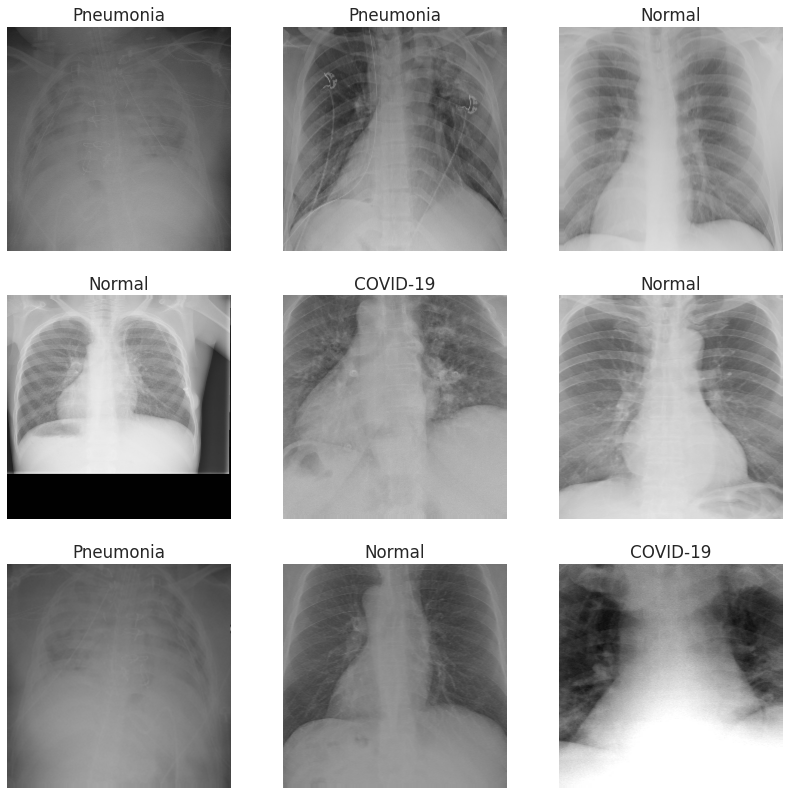

In [ ]:
print('9 IMAGENES RANDOM TRAIN')
random_index = np.random.randint(low=0, high=params_generator['batch_size'], size=(3,3))    #muestro de forma aleatoria algunas de las imagenes del batch
show_9_image(random_index, train_generator)

##### Show 9 random imagen TRAIN set - Select from 1 batch

9 IMAGENES RANDOM TEST


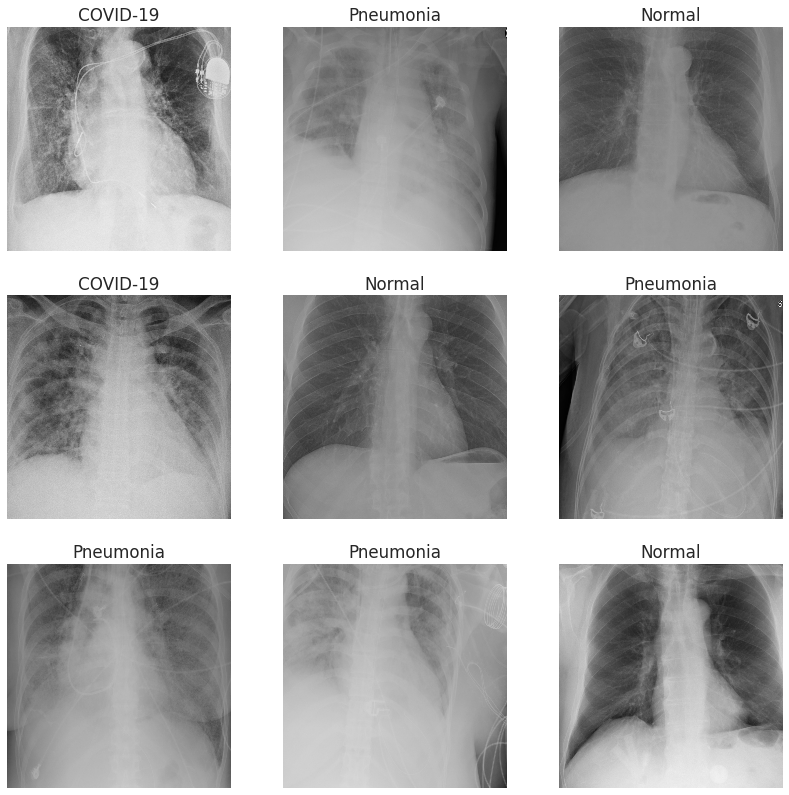

In [ ]:
print('9 IMAGENES RANDOM TEST')
random_index = np.random.randint(low=0, high=params_generator['batch_size'], size=(3,3))    #muestro de forma aleatoria algunas de las imagenes del batch
show_9_image(random_index, test_generator)

### Modelo (20 pts.)

Para entrenar nuestro algoritmo utilizaremos un famoso modelo llamado [ResNet](https://arxiv.org/abs/1512.03385) (He et al. 2015). El cual consistirá en un modelo que cuenta con 50 capas convolucionales residuales (ResNet50). 
Para obtener mejores resultados, en lugar de inicializar los pesos de manera aleatoria, se inicializarán utilizando los pesos de una red entrenada sobre [ImageNet](http://www.image-net.org/) (la competencia de clasificación de imágenes más famosa en visión computacional).
La capa de salida de esta arquitectura será reemplazada por una capa lineal de 3 nodos, con función de activación softmax, que nos dará la probabilidad para cada uno de nuestras clases.

Para entrenar este modelo:
1. Ocupe Adam como optimizador, utilizando un learning rate de 0.00001.
2. Reporte las métricas de accuracy y f1-score.
3. Ocupe como criterio de convergencia EarlyStopping (si la metrica f1-score macro no mejora durante más de 10 épocas sobre el conjunto de validación, entonces el entrenamiento debe detenerse).
4. Guarde los pesos del modelo entrenado sólo si éste presenta mejoras en la métrica de f1-score macro (medida sobre el conjunto de validación)


In [ ]:
resnet50_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor= None,
    input_shape= (224,224,3),  #tamaño final de X_train despues de data augmentation
    pooling=None,
)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 8s 0us/step


In [ ]:
#Capa de salida de resnet50
layers = resnet50_model.output

#flatten layer
layers = Flatten()(layers)

#Fc SOFTMAX 3
predictions = Dense(3, activation = 'softmax', name = 'FinalFC')(layers)

final_resnet50 = Model(inputs = resnet50_model.input, outputs = predictions)

In [ ]:
final_resnet50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [ ]:
#parameters
lr = 0.00001
num_epochs = 100  #termina con early stopping

## OBS
F1-Score no está implementado directamente en Keras y para utilizarlo en muchas páginas se recomienda crear una función e implementarlo como métrica lo cual calcularía el valor para cada batch y lo promediaría al final de la época lo cual es incorrecto. 

Otra forma que se menciona es implementarlo a a través de CallBack la cual calcularia f1 al final de cada época pero no existe disponibilidad en internet de un código y la forma que se recomienda es escribir el código en el backend de tensorflow, estudiando y haciendo una modificación al codigo fuente.

En muchas páginas se muestra el código hecho pero todas las que funciona son para problemas de clasificación binaria.
Por lo tanto a continuación el criterio modificado aplicando early stopping a la métrica de accuracy en el conjunto de validación, buscando ser de forma parecida a lo solicitado en el problema.

In [ ]:
#EARLY STOPPING WITH F1 SCORE EN CONJUNTO DE VALIDACIÓN
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1 , patience=10 ,min_delta=0.01 ,restore_best_weights=True)

In [ ]:
#PESAR LA FUNCIÓN DE COSTOS https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras

#PESAR LA FUNCION DE COSTOS DE ACUERDO A LA TOTALIDAD DE DATOS DE TRAIN
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_0),
                                                 y_train_0)
class_weights = dict(enumerate(class_weights))
print('PESOS FUNCIÓN DE COSTOS: ', class_weights)

PESOS FUNCIÓN DE COSTOS:  {0: 0.5815549418361369, 1: 0.8416908914728682, 2: 10.82398753894081}


In [ ]:
opt = kr.optimizers.Adam(learning_rate=lr)

final_resnet50.compile(
    loss = 'sparse_categorical_crossentropy',   #y predicho prob, y real 0,1,2
    optimizer = opt,
    metrics = ['acc']
)

In [ ]:
history_resnet50 = final_resnet50.fit_generator(
    generator = train_generator,
    validation_data = test_generator,    #usando el conjunto de test como validacion
    verbose = 1,  #1 progress bar
    epochs = num_epochs,
    class_weight = class_weights,
    callbacks = [es] 
)

Epoch 1/100
248/434 [================>.............] - ETA: 1:06:17 - loss: 0.8378 - acc: 0.7136

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 302 could not be retrieved. It could be because a worker has died.
  UserWarning)


433/434 [============================>.] - ETA: 21s - loss: 0.7082 - acc: 0.7537

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 26 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 42 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 45 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 47 could not be retrieved. It could be because a worker has died.
  UserWarning)


434/434 [==============================] - 10203s 24s/step - loss: 0.7073 - acc: 0.7537 - val_loss: 1.3297 - val_acc: 0.4056
Epoch 2/100
434/434 [==============================] - 1085s 2s/step - loss: 0.4176 - acc: 0.8441 - val_loss: 0.9189 - val_acc: 0.6728
Epoch 3/100
434/434 [==============================] - 1043s 2s/step - loss: 0.3389 - acc: 0.8692 - val_loss: 0.4405 - val_acc: 0.8361
Epoch 4/100
434/434 [==============================] - 1040s 2s/step - loss: 0.3059 - acc: 0.8839 - val_loss: 0.5005 - val_acc: 0.8782
Epoch 5/100
434/434 [==============================] - 988s 2s/step - loss: 0.2430 - acc: 0.8954 - val_loss: 0.8324 - val_acc: 0.8265
Epoch 6/100
434/434 [==============================] - 993s 2s/step - loss: 0.2137 - acc: 0.9037 - val_loss: 0.1591 - val_acc: 0.8833
Epoch 7/100
434/434 [==============================] - 993s 2s/step - loss: 0.1987 - acc: 0.9093 - val_loss: 0.3569 - val_acc: 0.9043
Epoch 8/100
434/434 [==============================] - 981s 2s/step 

### Curvas de aprendizaje (5 pts.):

Muestre las curvas de aprendizaje obtenidas luego del entrenamiento, tanto para la función de costos como para las métricas exigidas.

In [ ]:
def visualize_results_resnet50(train_loss, train_acc, test_loss, test_acc):
  #visualize acc, loss and f1 for each epoch in train and validation/test. 

  fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = ((14, 10)))
  ax = axs[0]
  ax.set_title('Loss', fontsize = 25)
  ax.grid(color = 'black', alpha = 0.5, linestyle = 'dashed', linewidth = 0.5)
  ax.plot(train_loss, label = 'loss_train', color = 'black', linestyle = '-')
  ax.plot(test_loss, label = 'loss_test', color = 'orange')
  ax.set_xlabel('Epochs', fontsize = 13)
  ax.legend()

  ax = axs[1]
  ax.set_title('Accuracy', fontsize = 25)
  ax.grid(color = 'black', alpha = 0.5, linestyle = 'dashed', linewidth = 0.5)
  ax.plot(train_acc, label = 'acc_train', color = 'black', linestyle = '-')
  ax.plot(test_acc, label = 'acc_test', color = 'orange')
  ax.set_xlabel('Epochs', fontsize = 13)
  plt.legend()

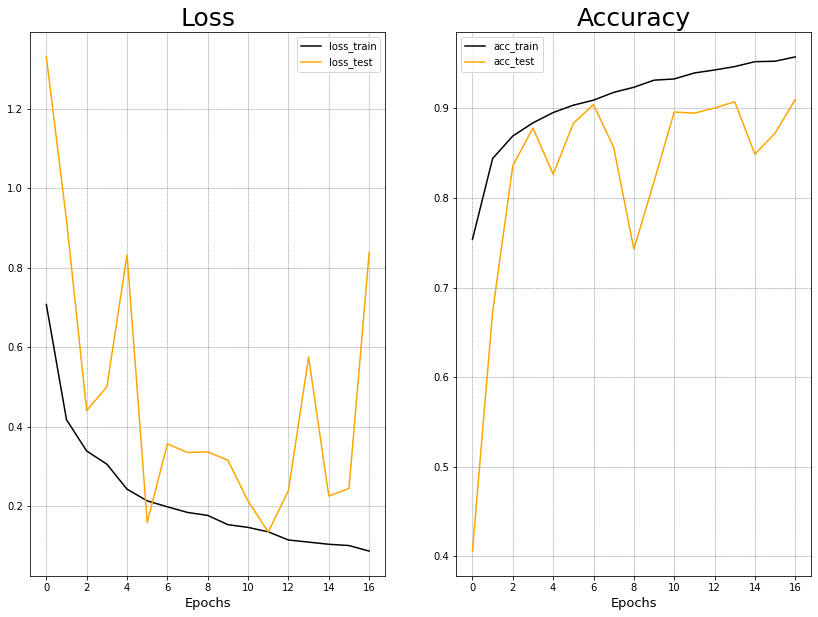

In [ ]:
visualize_results_resnet50(history_resnet50.history['loss'],
                          history_resnet50.history['acc'],
                          history_resnet50.history['val_loss'], 
                          history_resnet50.history['val_acc'])

In [ ]:
#resultado final f1-score MACRO

In [ ]:
n_batches = int(np.floor(len(y_test_0) / params_generator['batch_size']) )  #numero batches en test set

In [ ]:
print('F1-Score Macro TEST: ')
print('{:.2f}'.format(f1_score(np.concatenate ([test_generator[i][1] for i in range(  n_batches )]), np.argmax(final_resnet50.predict_generator( test_generator, steps= n_batches), axis=1) , average='macro'))  )

F1-Score Macro TEST: 
0.84


### Metrica final (10 pts.)

Muestre la matriz de confusión obtenida sobre los datos de test. Debería obtener algo como lo que se muestra a continuación.

In [ ]:
c_matrix = confusion_matrix(
    np.concatenate ([test_generator[i][1] for i in range(  n_batches )]) ,    
    np.argmax(final_resnet50.predict_generator( test_generator, steps= n_batches), axis=1)  
)
c_matrix

array([[811,  52,  15],
       [ 41, 539,  26],
       [  6,   9,  69]])

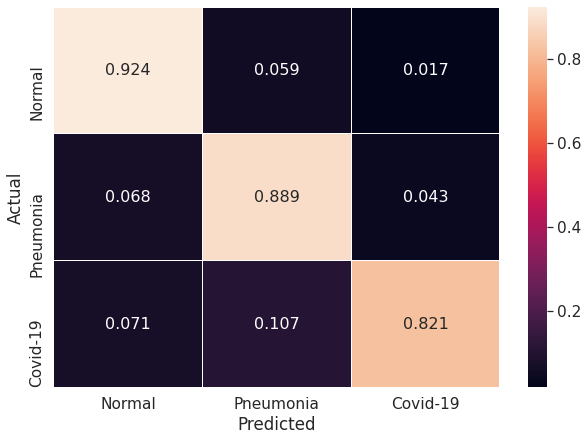

In [ ]:
%matplotlib inline

y_pred = ['Normal', 'Pneumonia', 'Covid-19']
df_cm = pd.DataFrame(c_matrix, columns=['Normal', 'Pneumonia', 'Covid-19'], index = ['Normal', 'Pneumonia', 'Covid-19'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
#sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size   #NO ESCALADA
sns.heatmap(df_cm.div(df_cm.sum(axis = 1), axis =0),  annot = True, fmt = '.3f', linewidths=.5, annot_kws={"size": 16})# font size   #ESCALADA

## BONUS (5 pts.):

Tanto en el paper como en esta implementación existe un error metodológico muy común, pero a la misma vez muy grave, el cual dice relación con los conjuntos de datos. Diga cuál es este error y porqué es importante corregirlo.

El error presente en la metodología del paper y de este trabajo es que se trabaja solo con un conjunto de train y de test, donde este último es utilizado también como un conjunto de validación, cumpliendo una doble función, testeo y validación.

Lo correcto en dicho paper es separar la muestra de entrenamiento en otro 10% para un conjunto de validación que se pueda utilizar para calcular las métricas en cada una de los pasos de gradiente de cada época y posteriormente usar un conjunto de test que no se halla visto en ninguna de las etapas de entrenamiento para validar el modelo por ejemplo a través de la matriz de confusión.

In [ ]:
#guardar modelo de forma manual
checkpoint_filepath = 'checkpoint.ckpt'
final_resnet50.save_weights(checkpoint_filepath)

#from google.colab import files
#files.download( 'checkpoint.ckpt' )  

!cp checkpoint.ckpt "/content/drive/My Drive/"